# Reconhecimento de algarismos manuscritos usando Clusters

### _JOÃO GABRIEL C. SILVA_

## Abstrato

O objetivo do projeto é criar um algoritmo capaz de, após uma etapa de criação de clusters, classificar corretamente um algarismo manuscrito numa imagem 8x8 como pertencente a um desses clusters, assim categorizando-o corretamente. Mediremos a eficiência do algoritmo de *clustering* em múltiplos tipos de amostras, variando o tipo de escrita e local do algarismo, afim de estimar sua usabilidade em problemas de magnitudes maiores atualmente.

## Introdução

A identificação de caracteres é um problema de ampla abrangência, cujo os usos podem ser encontrados nas mais diversas situações, desde a leitura de placas de carro até a conversão de documentos PDF para texto. De acordo com a universidade Oxford, o uso de OCR *(Optical character recognition)* teve um aumento expressivo nos anos 2000, sem quedas desde então, caracterizando a tecnologia como detentora de uma incalculável importância nos tempos atuais.

![Uso de OCR](https://www.gstatic.com/onebox/dictionary/ngram/en/desktop/c0b90b60b46562095b53b47d26ebf54bf1320ad7.png)

Dada a importância do OCR, é presumível a existência de diversas técnicas contidas neste escopo, e constatável em *A Review on Optical Character Recognition Techniques (Modi and Parikh 2017)*. Neste projeto, utilizaremos a técnica de Clustering.

O método de clustering usa N características para separar os dados contidos no dataset em clusters. Após a separação dessas massas de dados, calculamos o centro do cluster a partir de todas as amostras nele contidas. A classificação de novas amostras é feita a partir da comparação de sua distância para o centro de cada cluster, a amostra será classificada como pertencente ao cluster cujo centro estiver mais próximo.

Para resolver este problema da maneira mais eficiente possível, criaremos alguns tipos diferentes de datasets e quantificaremos, através de observações empíricas, a eficiência do algoritmo em cada caso, procurando aperfeiçoá-lo.

## Método

### Os datasets

Cada amostra é composta por um tensor bidimensional, uma array 8x8 contendo valores de 0 a 1 que ditam a intensidade da cor de cada pixel de uma imagem em grayscale.

Sendo 
$$A = (aij)8x8$$
    
O valor é contido em cada pixel aij.

In [9]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import cv2
import tqdm


Este tensor bidimensional contem a matriz

 [[0.   0.02 0.03 0.04 0.05 0.06 0.07 0.08]
 [0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16]
 [0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24]
 [0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32]
 [0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 ]
 [0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48]
 [0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56]
 [0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64]
 [0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72]
 [0.78 0.79 0.8  0.81 0.82 0.83 0.84 1.  ]] 

E é equivalente à esta imagem:


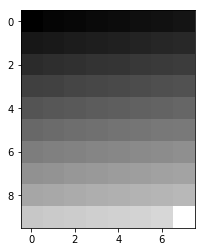

In [10]:
example_array = [
    (.0, .02, .03, .04, .05, .06, .07, .08),
    (.09, .1, .11, .12, .13, .14, .15, .16),
    (.17, .18, .19, .2, .21, .22, .23, .24),
    (.25, .26, .27, .28, .29, .3, .31, .32),
    (.33, .34, .35, .36, .37, .38, .39, .4),
    (.41, .42, .43, .44, .45, .46, .47, .48),
    (.49, .5, .51, .52, .53, .54, .55, .56),
    (.57, .58, .59, .6, .61, .62, .63, .64),
    (.65, .66, .67, .68, .69, .7, .71, .72),
    (0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 1)
]

example_array = np.asarray(example_array, dtype=np.dtype("float32"))
print("\nEste tensor bidimensional contem a matriz\n\n", example_array, "\n\nE é equivalente à esta imagem:")
plt.imshow(example_array, cmap="gray")
plt.show()

Sendo assim, a imagem contendo o algarismo 9 manuscrito numa grid 8x8:

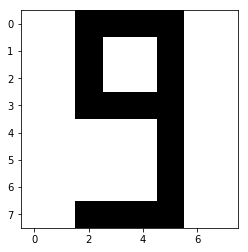

In [11]:
#Imagem
img = plt.imread("./train/9/2.PNG")
plt.imshow(img, cmap="gray")
plt.show()

é nada mais que o tensor:

In [12]:
#Tensor da imagem
print(img)

[[1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]]


Desta maneira, é simples o processo de criação do dataset necessário; Usaremos uma ferramenta de imagem, no caso o photoshop, para escrever algarismos em imagens 8x8 pixels, no modo *grayscale* (ou "tons de cinza"). Buscando a maior eficiência possível, criaremos o dataset com o máximo possível de variações do algarismo em cada caso, e procuraremos obter cerca de 50 amostras para cada possível rótulo. Na estrutura do repositório, o dataset descrito se encontra dentro da pasta "train", e as amostras estão distribuidas entre as pastas com seus respectivos rótulos.

In [13]:
#Número de samples pra cada label
for directory in os.listdir("./train/"):
    print("label = %s | N_samples =  %s\n---------------------------"%(directory, len(os.listdir("./train/%s"%directory))))

label = 4 | N_samples =  28
---------------------------
label = 5 | N_samples =  36
---------------------------
label = 6 | N_samples =  30
---------------------------
label = 7 | N_samples =  55
---------------------------
label = 8 | N_samples =  38
---------------------------
label = 9 | N_samples =  49
---------------------------


a variância dos algarismos pode ser representada pelas imagens a seguir, que pertencem ao mesmo label, e provém de alterações no tamanho, posição e estilo de escrita do algarismo.

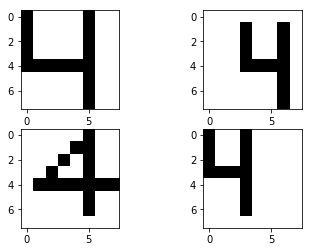

In [15]:
quatro_0 = plt.imread("./train/4/10.png")
quatro_1 = plt.imread("./train/4/12.png")
quatro_2 = plt.imread("./train/4/1.png")
quatro_3 = plt.imread("./train/4/11.png")
images = [quatro_0, quatro_1, quatro_2, quatro_3]
for i in range(len(images)):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')

### Clusterização

Após a criação de um dataset de treino consistente, criaremos os clusters. Para isso, precisaremos de N *features*. Considerando o problema em questão utilizaremos o centro de massa das amostras como features, tendo assim duas features, sendo elas x, y da coordenada equivalente ao centro de massa da imagem. Para calcular o centro de massa, devemos extrair a média dos valores contidos em todas as linhas e a mesma coisa para as colunas. 

Afim de receber coordenadas mais incisivas para os centros de massa, inverteremos os valores binários do tensor, de maneira que a parcela majoritária dele seja 0 invés de 1.

In [16]:
#invert binary arrays
def invert_binary(img):
    for i in range(0, len(img)):
        for j in range(0, len(img[i])):
            if img[i][j] == 1:
                img[i][j] = 0
            else:
                img[i][j] = 1
    return img

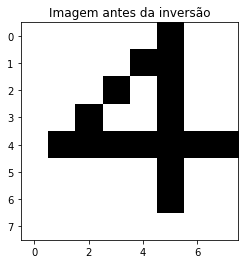

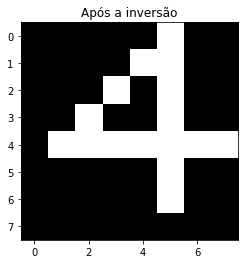

In [17]:
plt.imshow(quatro_2, cmap="gray")
plt.title("Imagem antes da inversão")
plt.show()

invertido = invert_binary(quatro_2)
plt.imshow(invertido, cmap="gray")
plt.title("Após a inversão")
plt.show()

Após a inversão, calculamos o centro de massa da imagem, porém com um detalhe: Para tornar os centros de massa mais heterogêneos, converteremos cada linha e coluna para um valor decimal a partir do binário formado através dela.

In [18]:
#Calculando o centroid usando a conversão de valores binários para decimais através das linhas e colunas
def calc_decimal_centroid(img):
    x_decimal = []
    for i in range(0, len(img)):
        x = 0
        x += img[i][0]*128
        x += img[i][1]*64
        x += img[i][2]*32
        x += img[i][3]*16
        x += img[i][4]*8
        x += img[i][5]*4
        x += img[i][6]*2
        x += img[i][7]*1
        x_decimal.append(x)

    b = 0
    for i in x_decimal:
        b+=i
    x_avg = b/len(x_decimal)
    
    y_decimal = []    
    for i in range(0, len(img)):
        y = 0
        y += img[0][i]*128
        y += img[1][i]*64
        y += img[2][i]*32
        y += img[3][i]*16
        y += img[4][i]*8
        y += img[5][i]*4
        y += img[6][i]*2
        y += img[7][i]*1
        y_decimal.append(y)
        
    b = 0
    for i in y_decimal:
        b+=i
    y_avg = b/len(y_decimal)
    
    return x_avg, y_avg

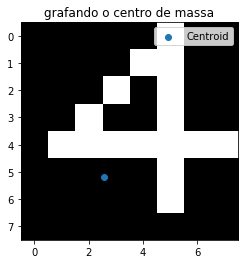

In [19]:
centro_x, centro_y = calc_decimal_centroid(invertido)
plt.imshow(invertido,cmap="gray")
plt.title("grafando o centro de massa")
plt.scatter(centro_x/10, centro_y/10, label="Centroid")
plt.legend()
plt.show()

Para a efetiva criação de um cluster, usaremos nosso dataset para extrair o centro de massa de cada imagem, e calcularemos o centro do cluster a partir da média entre todas as coordenadas de pontos pertencentes ao mesmo cluster.



In [20]:
#Calcula o centro de cluster baseado em N amostras extraídas a partir de uma arquitetura de diretórios específica
def map_centers(folder, mode="decimal"):
    numbers = {}
    centers = {}
    for alg in os.listdir(folder):
        numbers[int(alg)] = []
        for image in os.listdir("%s/%s/"%(folder, alg)):
            img = plt.imread("%s/%s/%s"%(folder,alg, image))
            img = invert_binary(img)
            
            if mode == "binary":
                numbers[int(alg)].append(calc_binary_centroid(img))
            elif mode == "decimal":
                numbers[int(alg)].append(calc_decimal_centroid(img))
            else:
                print("invalid mode")
                return False
            
    for number in numbers:
        all_x = []
        all_y = []
        for coord in numbers[number]:
            all_x.append(coord[0])
            all_y.append(coord[1])
        all_x = np.asarray(all_x, dtype=np.dtype("float32"))
        all_y = np.asarray(all_y, dtype=np.dtype("float32"))
        mean_x = all_x.mean()
        mean_y = all_y.mean()
        centers[number] = [mean_x, mean_y]

    #Grafa os centro de massa de todas as amostras e os centros de cada cluster
    c = 0
    colors = cm.rainbow(np.linspace(0, 1, len(numbers.keys())))
    for number in numbers.keys():
        lc = 0
        for coord in numbers[number]:
            if lc == 0:
                plt.scatter(coord[0], coord[1], color=colors[c], label="%s"%number)
                lc+=1
            else:
                plt.scatter(coord[0], coord[1], color=colors[c])
        c+=1
    for number in centers:
        plt.scatter(centers[number][0],centers[number][1], label="center of %s"%number)
    plt.legend()
    plt.show()
    return numbers, centers

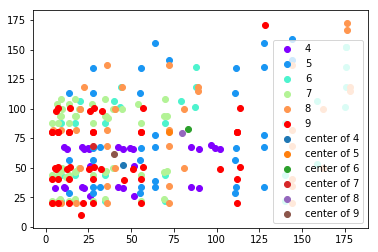

In [21]:
numbers, centers = map_centers("./train/", mode="decimal")

O gráfico ostenta o centro de cada cluster, e grafa cada ponto com a cor do cluster ao qual pertence baseado em seu rótulo. A partir deste gráfico, é fácil constatar que os centros de massa são extremamente homogêneos, e não possuem variância o suficiente para a clusterização adequada. Para uma observação empírica, realizaremos uma etapa de validação;

* Calcularemos o centro de massa de N amostras cujo rótulo é conhecido
* Calcularemos, usando distância euclidiana, a distância entre o centro de massa das novas amostras e o centro de cada cluster
    * Classificaremos cada nova amostra como pertencente ao Cluster cujo centro estiver mais próximo
    * Calcularemos a taxa de acerto do algoritmo treinado no dataset autal comparando a classificação feita pelo algoritmo com o real rótulo da amostra

Hipótese

$$
f(x^{(i)}) =  
\begin{cases} 
1 &y^{(i)} = c\\
0 &y^{(i)} \ne c
\end{cases}
$$

Taxa de acerto

$$A =\frac{\sum^{m}_{i=1}f(x^{(i)})}{m}$$

Onde 

$m = $ tamanho do dataset

$c = $ Centro de Cluster mais próximo de $ x^{(i)} $

$x^{(i)} = $ *features* da iª amostra do dataset

$y^{(i)} = $ *label* (rótulo) da iª amostra do dataset

In [22]:
#Distância euclidiana
def distance(x,y, x1,y1):
    return np.sqrt((x1-x)**2 + (y1-y)**2)

#Classificador com modo supervisionado ou não supervisionado
def classify(x, y, centers, label=False):
    smallest_dist = [None,None]
    for center in centers:
        dist = distance(x,y, centers[center][0],centers[center][1])
        if smallest_dist == [None,None]:
            smallest_dist = [center, dist]
        elif dist < smallest_dist[1]:
            smallest_dist = [center, dist]
    if label != False:
        if label == smallest_dist[0]:
            return (True, smallest_dist[0], smallest_dist[1])
        else:
            return(False, smallest_dist[0], smallest_dist[1])
    else:
        print(smallest_dist)

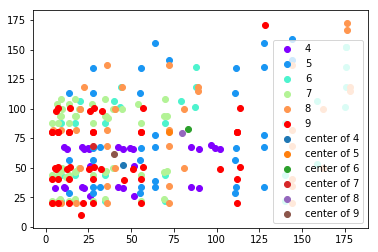

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 41.38it/s]


validation accuracy = 0.263


In [25]:
#Mapeando os clusters
numbers, centers = map_centers("./train/", mode="decimal")

#Realizando classificação e calculando a acurácia do algortimo com os clusters atuais.
total_evaluated = 0

missed = []
correct = []
trying = []
for label in tqdm.tqdm(os.listdir("./train/")):
    for sample in os.listdir("./train/%s"%label):
        if int(label) in centers:
            img = plt.imread("./train/%s/%s"%(label,sample))
            img = invert_binary(img)
            
            #img = resize(img)
            
            img_mass_center_x, img_mass_center_y = calc_decimal_centroid(img)
            predicted = classify(img_mass_center_x, img_mass_center_y, centers, label=int(label))
            if predicted[0] == True:
                correct.append([predicted[1], predicted[2]])
                trying.append(1)
            else:
                missed.append([predicted[1], predicted[2]])
                trying.append(0)
            #plt.imshow(img, cmap="gray")
            #plt.show()
            #print(predicted)
            total_evaluated +=1 
        else:
            pass

#Calculate accuracy
print("validation accuracy = %s"%(round(np.mean(np.asarray(trying, dtype=np.dtype("int"))), 3)))

Obtivemos  
$A = 26.3\%$

onde A é a taxa de acurácia obtida na etapa de validação. Apesar de, para o dataset utilizado, a taxa de acerto ser superior a probabilidade de acerto por chance (16.6%), os resultados não são nem próximos de satisfatórios.

### Experimentação com novo dataset

A partir dos resultados da etapa de validação anterior, formulamos a hipótese de que a natureza de uma imagem de 8x8 pixels, somada a ausência de ocupação de pixels no caso das amostras que não ocupassem toda a *grid* resultaria num centro de massa pouco expressivo, incapaz de captar "a essência" dos algarismos no plano bidimensional estipulado pelas *features* utilizadas. Para testar essa hipótese:
* Criaremos um dataset reduzido, composto apenas de imagens que ocupem o máximo possível da área da imagem
    * Realizaremos o processo de clusterização deste novo dataset
        * Calcularemos o desvio padrão entre os centros de cluster de cada mapa de clusters para estimar a homogeneidade dos centros de massa (como o dataset reduzido possui menos categorias que o dataset de treino, faremos o cálculo utilizando apenas as categorias presentes nos dois datasets, evitando contaminar a análise)
        * Realizaremos o processo de validação no novo mapa de clusters

Abaixo, podemos ver a diferença entre os tipos de amostras contidos em cada dataset.

Exemplos de amostras no dataset de treino


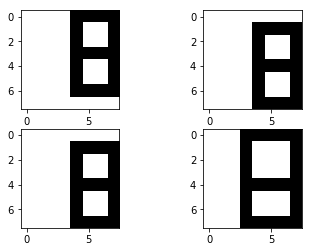



Exemplos de amostras no dataset reduzido


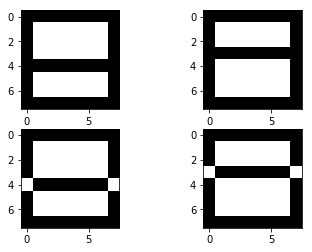

In [6]:
train_images = []
for image in os.listdir("./train/8/"):
    img = plt.imread("./train/8/%s"%image)
    train_images.append(img)
    
reducted_images = []
for image in os.listdir("./reducted/8/"):
    img = plt.imread("./reducted/8/%s"%image)
    reducted_images.append(img)
    
print("Exemplos de amostras no dataset de treino")
for i in range(0,len(reducted_images)):
    plt.subplot(2,2,i+1),plt.imshow(train_images[i],'gray')
plt.show()

print("\n\nExemplos de amostras no dataset reduzido")
for i in range(0,len(reducted_images)):
    plt.subplot(2,2,i+1),plt.imshow(reducted_images[i],'gray')
plt.show()

A partir deste novo dataset reduzido, com imagens centradas e consumindo o máximo possível de área da grid 8x8, calcularemos o desvio padrão dos centros de seus clusters e compararemos com a mesma métrica do dataset de treino.

Train dataset:


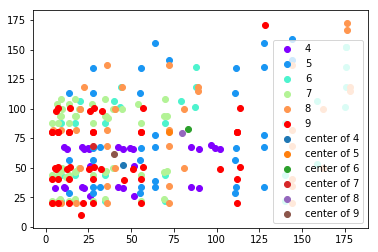



Reducted dataset:


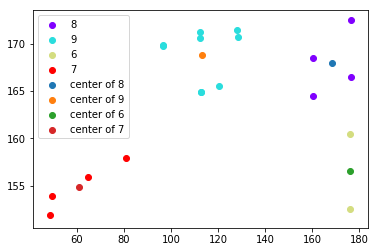

Train dataset:
  x deviation: 24.348297
  y deviation: 8.3486595


Reducted dataset:
  x deviation: 46.42031
  y deviation: 6.3825536


In [29]:
#Gerando os mapas de clusters com o dataset de treino
print("Train dataset:")
labels_1, centers_train = map_centers("./train/", mode="decimal")
#Gerando os mapas de clusters com o dataset reduzido
print("\n\nReducted dataset:")
labels_2, centers_reducted = map_centers("./reducted/", mode="decimal")


#Calculando o desvio padrão entre as coordenadas
every_center_train = []
for label in centers_reducted:
    every_center_train.append(centers_train[label])
    
every_center_reducted = []
for label in centers_reducted:
    every_center_reducted.append(centers_reducted[label])
    
every_x_train = []
every_y_train = []
for coords in every_center_train:
    every_x_train.append(coords[0])
    every_y_train.append(coords[1])
print("Train dataset:")
print("  x deviation:", np.std(every_x_train))
print("  y deviation:", np.std(every_y_train))

print("\n")

every_x_reducted = []
every_y_reducted = []
for coords in every_center_reducted:
    every_x_reducted.append(coords[0])
    every_y_reducted.append(coords[1])
print("Reducted dataset:")
print("  x deviation:", np.std(every_x_reducted))
print("  y deviation:", np.std(every_y_reducted))

É possível constatar um desvio padrão muito mais incisivo no dataset reduzido, isso significa que os clusters neste mapa são mais difusos, facilitando a classificação apropriada das amostras. A realização da etapa de validação neste novo mapa de clusters (a partir do dataset reduzido) quantificará a melhoria do algoritmo quando usando esse novo tipo de amostra.

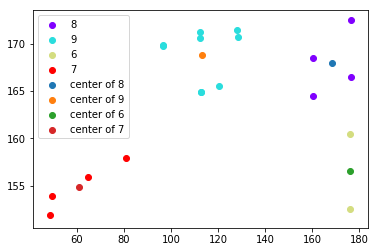

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 286.62it/s]


validation accuracy = 1.0


In [32]:
#Mapeando os clusters
numbers, centers = map_centers("./reducted/", mode="decimal")

#Realizando classificação e calculando a acurácia do algortimo com os clusters atuais.
total_evaluated = 0

missed = []
correct = []

for label in tqdm.tqdm(os.listdir("./reducted/")):
    for sample in os.listdir("./reducted/%s"%label):
        if int(label) in centers:
            img = plt.imread("./reducted/%s/%s"%(label,sample))
            img = invert_binary(img)
            
            #img = resize(img)
            
            img_mass_center_x, img_mass_center_y = calc_decimal_centroid(img)
            predicted = classify(img_mass_center_x, img_mass_center_y, centers, label=int(label))
            if predicted[0] == True:
                correct.append([predicted[1], predicted[2]])
            else:
                missed.append([predicted[1], predicted[2]])
            #plt.imshow(img, cmap="gray")
            #plt.show()
            #print(predicted)
            total_evaluated +=1 
        else:
            pass

#Calculate accuracy
print("validation accuracy = %s"%(round(len(correct)/total_evaluated, 3)))

Dessa vez, obtivemos

$A = 100\%$

Apesar de a quantidade de amostras presentes no dataset reduzido serem significativamente menores que em nosso dataset de treino, temos uma melhora magnífica em nosso passo de validação.

Dada nossa hipótese, precisamos agora ajustar nossos tipos de dados contidos no dataset de treino (e possivelmente novos dados inseridos para classificação). A solução ideal é atualizar as amostras de maneira que, mantendo o *aspect ratio* do algarismo, façamos com que ele ocupe a maior área possível na grid 8x8.

Para isso, utilizaremos visão computacional e manipulação do tensor.

Utilizemos como exemplo um dos quatro contidos no dataset de treino.

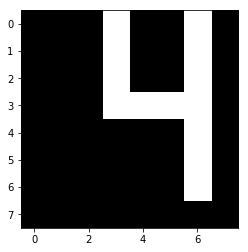

In [8]:
img = plt.imread("./train/4/12.PNG")
img = invert_binary(img)
plt.imshow(img, cmap="gray")
plt.show()

Primeiro, precisamos excluir qualquer coluna ou linha que não contenha nenhuma parte do algarismo.

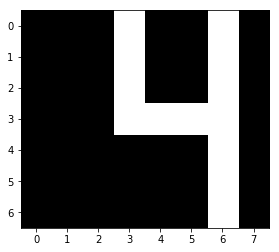

In [9]:
#Excluindo linhas vazias
rows = []
for i in range(0,len(img)):
    c = 0
    for j in range(0,len(img[i])):
        if img[i][j] == 1:
            c=+1
            break
    if c == 0:
        rows.append(i)
if len(rows) > 0:
    img = np.delete(img, rows, axis=0)

plt.imshow(img,cmap="gray")
plt.show()

Em seguida, deletaremos as linhas vazias na matriz transposta da imagem.

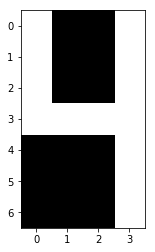

In [10]:
#Excluindo colunas vazias
rows = []
img = img.T
for i in range(0,len(img)):
    c = 0
    for j in range(0,len(img[i])):
        if img[i][j] == 1:
            c=+1
            break
    if c == 0:
        rows.append(i)
if len(rows) > 0:
    img = np.delete(img, rows, axis=0)
img = img.T

plt.imshow(img, cmap="gray")
plt.show()

Agora possuimos uma imagem 4x7. Em seguida, usaremos uma operação de visão computacional para redimensionar a imagem.

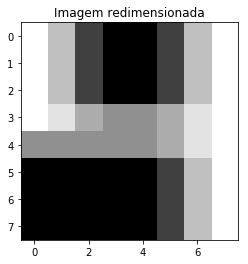

Tensor:
[[1.       0.75     0.25     0.       0.       0.25     0.75     1.      ]
 [1.       0.75     0.25     0.       0.       0.25     0.75     1.      ]
 [1.       0.75     0.25     0.       0.       0.25     0.75     1.      ]
 [1.       0.890625 0.671875 0.5625   0.5625   0.671875 0.890625 1.      ]
 [0.5625   0.5625   0.5625   0.5625   0.5625   0.671875 0.890625 1.      ]
 [0.       0.       0.       0.       0.       0.25     0.75     1.      ]
 [0.       0.       0.       0.       0.       0.25     0.75     1.      ]
 [0.       0.       0.       0.       0.       0.25     0.75     1.      ]]


In [15]:
#Resize image
resized_img = cv2.resize(img, (8, 8))
plt.imshow(resized_img, cmap="gray")
plt.title("Imagem redimensionada")
plt.show()

print("Tensor:\n%s"%resized_img)

A imagem foi redimensionada, e podemos constatar que o *aspect ratio* foi preservado, como desejado. Entretanto, os valores contidos na matriz não são mais apenas binários, e variam entre 0 e 1, ostentando diversas intensidades de cinza. Para sobrepujar esse problema, utilizaremos um *threshold* $T$ onde

$$T = \frac{\sum_{i=1}^8\sum_{j=1}^8a_{(ij)}}{8^2} $$

e, pra cada $aij$,
$$
a_{(ij)} = 
\begin{cases}
1 &a_{(ij)} >= T\\
0 &a_{(ij)} < T
\end{cases}
$$

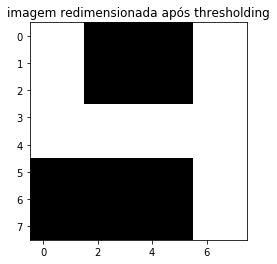

In [16]:
every = 0
for i in range(0, len(resized_img)):
    for j in range(0, len(resized_img[i])):
        every += resized_img[i][j]
        resized_img[i][j] = round(resized_img[i][j], 1)
median = every/(8*8)

#print(resized_img, "\n", median)

for i in range(0, len(resized_img)):
    for j in range(0, len(resized_img[i])):
        if resized_img[i][j] >= round(median,2):
            resized_img[i][j] = 1
        else:
            resized_img[i][j] = 0


plt.imshow(resized_img, cmap="gray")
plt.title("imagem redimensionada após thresholding")
plt.show()

Converteremos esse algoritmo numa função e testaremos em algumas amostras para constatar sua consistência.

In [41]:
def resize(img):
    rows = []
    for i in range(0,len(img)):
        c = 0
        for j in range(0,len(img[i])):
            if img[i][j] == 1:
                c=+1
                break
        if c == 0:
            rows.append(i)
    if len(rows) > 0:
        img = np.delete(img, rows, axis=0)


    rows = []
    img = img.T
    for i in range(0,len(img)):
        c = 0
        for j in range(0,len(img[i])):
            if img[i][j] == 1:
                c=+1
                break
        if c == 0:
            rows.append(i)
    if len(rows) > 0:
        img = np.delete(img, rows, axis=0)
    img = img.T


    resized_img = cv2.resize(img, (8, 8))

    every = 0
    for i in range(0, len(resized_img)):
        for j in range(0, len(resized_img[i])):
            every += resized_img[i][j]
            resized_img[i][j] = round(resized_img[i][j], 1)
    median = every/(8*8)

    for i in range(0, len(resized_img)):
        for j in range(0, len(resized_img[i])):
            if resized_img[i][j] >= round(median,2):
                resized_img[i][j] = 1
            else:
                resized_img[i][j] = 0

    return resized_img

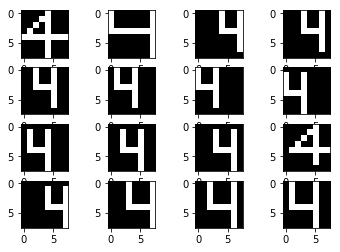

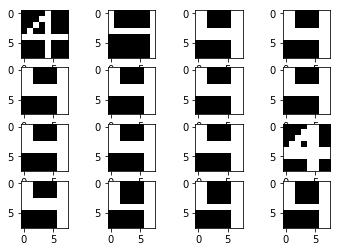

In [40]:
train_images = []
resized = []
for image in os.listdir("./train/4/"):
    img = plt.imread("./train/4/%s"%image)
    img = invert_binary(img)
    train_images.append(img)
    resized.append(resize(img))


for i in range(0, 16):
    plt.subplot(4,4,i+1),plt.imshow(train_images[i],'gray')
plt.show()

for i in range(0, 16):
    plt.subplot(4, 4, i+1),plt.imshow(resized[i],'gray')
plt.show()

Uma vez que testada a consistência do algoritmo de redimensionamento, podemos implementá-lo no processo de criação de clusters. Redefiniremos a função de clusterização;

In [43]:
def map_centers(folder, mode="decimal"):
    numbers = {}
    centers = {}
    for alg in os.listdir(folder):
        numbers[int(alg)] = []
        for image in os.listdir("%s/%s/"%(folder, alg)):
            img = plt.imread("%s/%s/%s"%(folder,alg, image))
            img = invert_binary(img)
            
            #adicionamos o passo de redimensionamento
            img = resize(img)
            
            if mode == "binary":
                numbers[int(alg)].append(calc_binary_centroid(img))
            elif mode == "decimal":
                numbers[int(alg)].append(calc_decimal_centroid(img))
            else:
                print("invalid mode")
                return False
            
    for number in numbers:
        all_x = []
        all_y = []
        for coord in numbers[number]:
            all_x.append(coord[0])
            all_y.append(coord[1])
        all_x = np.asarray(all_x, dtype=np.dtype("float32"))
        all_y = np.asarray(all_y, dtype=np.dtype("float32"))
        mean_x = all_x.mean()
        mean_y = all_y.mean()
        centers[number] = [mean_x, mean_y]

    c = 0
    colors = cm.rainbow(np.linspace(0, 1, len(numbers.keys())))
    for number in numbers.keys():
        lc = 0
        for coord in numbers[number]:
            if lc == 0:
                plt.scatter(coord[0], coord[1], color=colors[c], label="%s"%number)
                lc+=1
            else:
                plt.scatter(coord[0], coord[1], color=colors[c])
        c+=1
    for number in centers:
        plt.scatter(centers[number][0],centers[number][1], label="center of %s"%number)
    plt.legend()
    plt.show()
    return numbers, centers

Utilizaremos nossa função reformulada para mapear o cluster de treino novamente

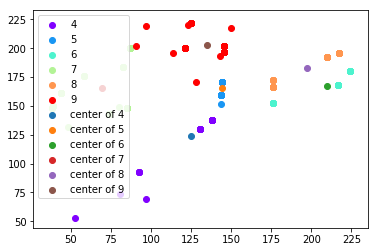

In [45]:
numbers, centers = map_centers("./train/", mode="decimal")

A diferença é incontestável. Dessa vez, temos clusters mais bem definidos, com distâncias maiores entre os centros. Realizando validação nos clusters mapeados a partir do dataset de treino novamente, é possível quantificar a eficiência do algoritmo;

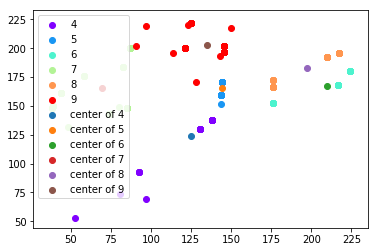

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 17.86it/s]


validation accuracy = 0.966


In [57]:
#Mapeando os clusters
numbers, centers = map_centers("./train/", mode="decimal")

#Realizando classificação e calculando a acurácia do algortimo com os clusters atuais.
total_evaluated = 0

missed = []
correct = []

for label in tqdm.tqdm(os.listdir("./train/")):
    for sample in os.listdir("./train/%s"%label):
        if int(label) in centers:
            img = plt.imread("./train/%s/%s"%(label,sample))
            img = invert_binary(img)
            
            #adicionamos um passo para redimensionar a imagem antes da classificação
            img = resize(img)
            
            img_mass_center_x, img_mass_center_y = calc_decimal_centroid(img)
            predicted = classify(img_mass_center_x, img_mass_center_y, centers, label=int(label))
            if predicted[0] == True:
                correct.append([predicted[1], predicted[2]])
            else:
                missed.append([predicted[1], predicted[2]])
            total_evaluated +=1 
        else:
            pass

#Calculate accuracy
print("validation accuracy = %s"%(round(len(correct)/total_evaluated, 3)))

Obtivemos

$A = 96.6\%$

A taxa de acerto foi 3.67 vezes maior que no modelo inicial, comprovando nossa hipótese a respeito dos espaços vazios contidos na matriz.

## Resultados

Após alguns ajustes no algoritmo, foi possível extrair o potencial da técnica de clusterização, alcançando 100% de acurácia no dataset reduzido, e 96.6% de acurácia no dataset de treino. Não obstante seu desempenho em etapas de validações realizadas em datasets usados para treino, afim de avaliar a performance do algoritmo em amostras não vistas na fase de treino, mapearemos os clusters usando o dataset de treino, faremos classificações supervisionadas no dataset de validação, que contém 10% do tamanho do dataset de treino.

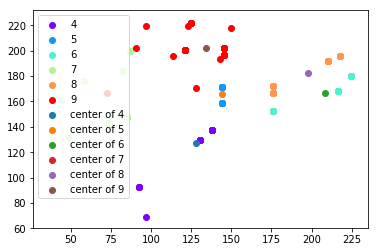

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157.74it/s]


validation accuracy = 1.0


In [71]:
numbers, centers = map_centers("./train/", mode="decimal")

total_evaluated = 0

missed = []
correct = []

#Validação usando dataset de validação
for label in tqdm.tqdm(os.listdir("./val/")):
    for sample in os.listdir("./val/%s"%label):
        if int(label) in centers:
            img = plt.imread("./val/%s/%s"%(label,sample))
            img = invert_binary(img)
            
            img = resize(img)
            
            img_mass_center_x, img_mass_center_y = calc_decimal_centroid(img)
            predicted = classify(img_mass_center_x, img_mass_center_y, centers, label=int(label))
            if predicted[0] == True:
                correct.append([predicted[1], predicted[2]])
            else:
                missed.append([predicted[1], predicted[2]])
            total_evaluated +=1 
        else:
            pass

#Calculate accuracy
print("validation accuracy = %s"%(round(len(correct)/total_evaluated, 3)))

Obtemos, então, o excelente resultado de

$A = 100\%$

para o dataset de validação. Através das observações empíricas e sistemáticas realizadas neste projeto, é clara a eficiência do algoritmo utilizado quando sob as circunstâncias corretas; A tecnica de clustering não alcançou 20% de acurácia antes da
implementação do algoritmo de redimensionamento, mas alcançou a 96.6 ~ 100% quando os dados eram heterogêneos o suficiente.

## Discussão

Através dos resultados obtidos, se torna clara a conclusão de que o uso da técnica de clustering, de maneira adequada, em OCR é eficiênte e pode resolver os mais diversos problemas no escopo apresentado.

A potência dessa técnica, porém, não se limita apenas ao âmbito de OCR. As análises demonstram que o algoritmo é robusto o suficiente para resolver outros problemas com eficácia, como por exemplo segmentação de imagens.

O problema resolvido neste projeto serve como uma ótima amostragem para o poder e os usos do algoritmo utilizado na solução; Uma vez que, ao aplicar diversas técnicas de *feature engineering* alcançamos altas performances em amostras com *features* tão homogêneas, é natural a conclusão de que problemas com features mais expressivas serão ainda mais simples de resolver.

Os experimentos também servem para reforçar que, apesar do estado-da-arte de classificação e segmentação de imagens estar povoado de redes neurais e outras técnicas poderosíssimas, porém que demandam hardware e tempo para a implementação correta, o algoritmo de clustering continua sendo uma alternativa extremamente eficiente e veloz, com baixa complexidade.